In [1]:
"""
Data sources: <https://data.open-power-system-data.org/index.php?package=time_series&version=2020-10-06&action=customDownload&resource=1&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bfrom%5D=2015-01-01&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bto%5D=2020-10-01&filter%5BRegion%5D%5B%5D=AT&filter%5BVariable%5D%5B%5D=solar_capacity&filter%5BVariable%5D%5B%5D=solar_generation_actual&filter%5BVariable%5D%5B%5D=solar_profile&downloadCSV=%E4%B8%8B%E8%BD%BDCSV>

Start of timeperiod in Central European (Summer-) Time: From 2015-01-01, To 2020-10-01
Region: Austria (AT)
Variables: solar_capacity, solar_generation_actual, solar_profile
Objective: Develop regression models for short-term photovoltaic (PV) power forecasting using historical generation data.
"""

'\nData sources: <https://data.open-power-system-data.org/index.php?package=time_series&version=2020-10-06&action=customDownload&resource=1&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bfrom%5D=2015-01-01&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bto%5D=2020-10-01&filter%5BRegion%5D%5B%5D=AT&filter%5BVariable%5D%5B%5D=solar_capacity&filter%5BVariable%5D%5B%5D=solar_generation_actual&filter%5BVariable%5D%5B%5D=solar_profile&downloadCSV=%E4%B8%8B%E8%BD%BDCSV>\n\nStart of timeperiod in Central European (Summer-) Time: From 2015-01-01, To 2020-10-01\nRegion: Austria (AT)\nVariables: solar_capacity, solar_generation_actual, solar_profile\nObjective: Develop regression models for short-term photovoltaic (PV) power forecasting using historical generation data.\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [3]:
# --- Data loading ---
# Read CSV with proper datetime parsing and index
use_cols = ["utc_timestamp", "AT_solar_generation_actual"]
df = pd.read_csv(
    "data/time_series_15min_singleindex_filtered.csv",
    usecols=use_cols,
    parse_dates=["utc_timestamp"],
    index_col="utc_timestamp",
    dtype={"AT_solar_generation_actual": "float32"},
)

df.head()

,AT_solar_generation_actual
utc_timestamp,
2014-12-31 23:00:00+00:00,NaN
2014-12-31 23:15:00+00:00,NaN
2014-12-31 23:30:00+00:00,NaN
2014-12-31 23:45:00+00:00,NaN
2015-01-01 00:00:00+00:00,NaN


In [4]:
# --- Cleaning & NaN policy ---
# Policy from user: night-time NaNs standardized to 0
# Simplest initial rule: any NaN becomes 0 (can refine later with solar-angle)
series = df["AT_solar_generation_actual"].copy()
series = series.fillna(0.0).astype("float32")

# Optional: clip small negatives due to noise
series = series.clip(lower=0)

# Replace in df_cleared for downstream use
df_cleared = pd.DataFrame({"AT_solar_generation_actual": series})
df_cleared.head()

,AT_solar_generation_actual
utc_timestamp,
2014-12-31 23:00:00+00:00,0.0
2014-12-31 23:15:00+00:00,0.0
2014-12-31 23:30:00+00:00,0.0
2014-12-31 23:45:00+00:00,0.0
2015-01-01 00:00:00+00:00,0.0


In [5]:
# Inspect cleaned data
print(df_cleared.info())
print("\nDate range:", df_cleared.index.min(), "->", df_cleared.index.max())
print("Rows:", len(df_cleared))
print("Non-zero share:", (df_cleared["AT_solar_generation_actual"] > 0).mean().round(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201604 entries, 2014-12-31 23:00:00+00:00 to 2020-09-30 23:45:00+00:00
Data columns (total 1 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AT_solar_generation_actual  201604 non-null  float32
dtypes: float32(1)
memory usage: 2.3 MB
None

Date range: 2014-12-31 23:00:00+00:00 -> 2020-09-30 23:45:00+00:00
Rows: 201604
Non-zero share: 0.587


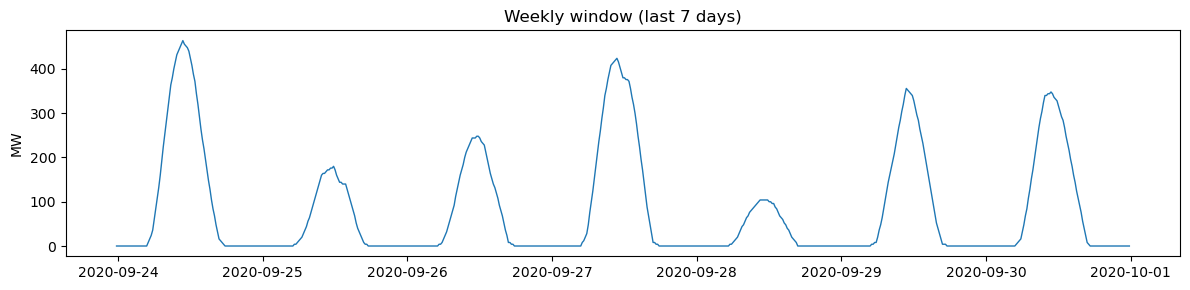

/tmp/ipykernel_12906/2017535513.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  down = df_cleared.resample("1H").mean(numeric_only=True)


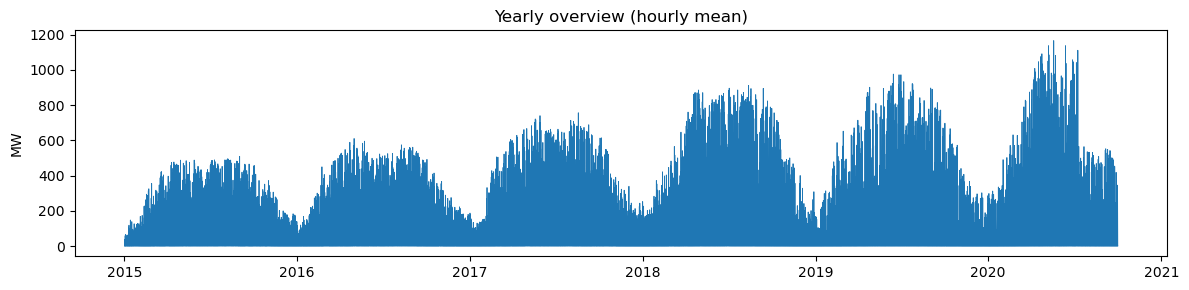

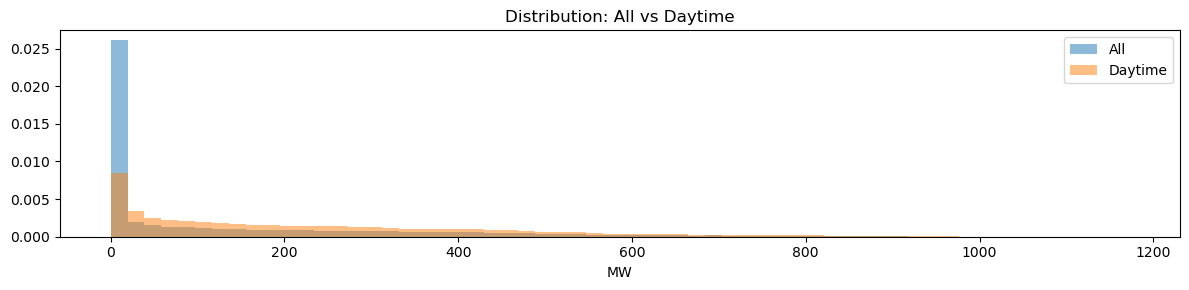

In [6]:
# --- DATA VISUALIZATION (1/2)  ---
# Daily/weekly windows, yearly overview, and distribution of daytime vs. all values.

# Weekly slice (last 7 days)
last_week_start = df_cleared.index.max() - pd.Timedelta(days=7)
mask_week = df_cleared.index >= last_week_start
plt.figure(figsize=(12,3))
plt.plot(df_cleared.index[mask_week], df_cleared["AT_solar_generation_actual"][mask_week], lw=1)
plt.title("Weekly window (last 7 days)")
plt.ylabel("MW"); plt.tight_layout(); plt.show()

# Yearly overview (downsample to hourly mean for clarity)
down = df_cleared.resample("1H").mean(numeric_only=True)
plt.figure(figsize=(12,3))
plt.plot(down.index, down["AT_solar_generation_actual"], lw=0.6)
plt.title("Yearly overview (hourly mean)")
plt.ylabel("MW"); plt.tight_layout(); plt.show()

# Daytime vs all values histogram
vals_all = df_cleared["AT_solar_generation_actual"].values
# Simple daytime proxy: value > 0 (works with NaN->0 policy)
vals_day = df_cleared.loc[df_cleared["AT_solar_generation_actual"] > 0, "AT_solar_generation_actual"].values
plt.figure(figsize=(12,3))
plt.hist(vals_all, bins=60, alpha=0.5, label="All", density=True)
plt.hist(vals_day, bins=60, alpha=0.5, label="Daytime", density=True)
plt.legend(); plt.title("Distribution: All vs Daytime"); plt.xlabel("MW"); plt.tight_layout(); plt.show()

In [7]:
# --- Time-based Train/Validation/Test (7/2/1) ---
# Use chronological split by fraction of index to avoid leakage
n = len(df_cleared)
train_end = int(n * 0.7)
val_end = int(n * 0.9)

s = df_cleared["AT_solar_generation_actual"].copy()

# --- Feature engineering: simple lags and rolling means ---
# 15min step; 1h=4, 2h=8, 24h=96
lags = [1, 4, 8, 96]
X = pd.DataFrame(index=s.index)
for L in lags:
    X[f"lag_{L}"] = s.shift(L)
X["roll_mean_4"] = s.shift(1).rolling(4).mean()
X["roll_mean_8"] = s.shift(1).rolling(8).mean()
X["roll_mean_96"] = s.shift(1).rolling(96).mean()

# Cyclic time features
idx = X.index
X["hour_sin"] = np.sin(2 * np.pi * idx.hour / 24)
X["hour_cos"] = np.cos(2 * np.pi * idx.hour / 24)
X["doy_sin"] = np.sin(2 * np.pi * idx.dayofyear / 365.25)
X["doy_cos"] = np.cos(2 * np.pi * idx.dayofyear / 365.25)

# Target
y = s.copy()

# Drop rows with NaNs due to lagging
data = X.join(y.rename("y")).dropna()

# Chronological split
train = data.iloc[:train_end]
val = data.iloc[train_end:val_end]
test = data.iloc[val_end:]

X_train, y_train = train.drop(columns=["y"]), train["y"]
X_val, y_val = val.drop(columns=["y"]), val["y"]
X_test, y_test = test.drop(columns=["y"]), test["y"]

(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((141122, 11), (141122,)), ((40321, 11), (40321,)), ((20065, 11), (20065,)))

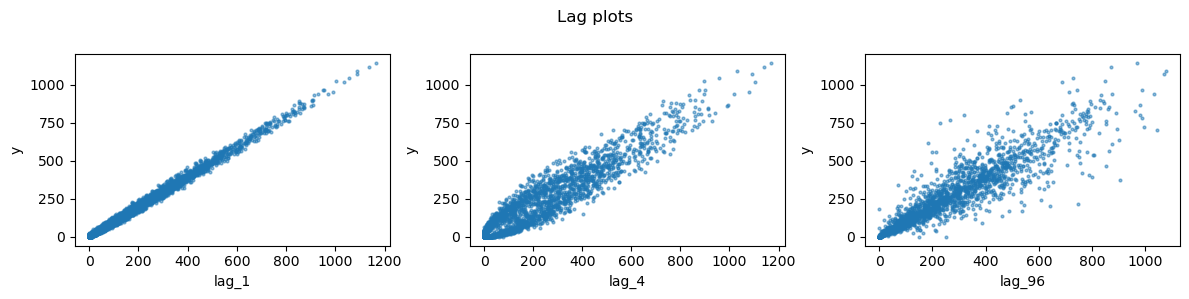

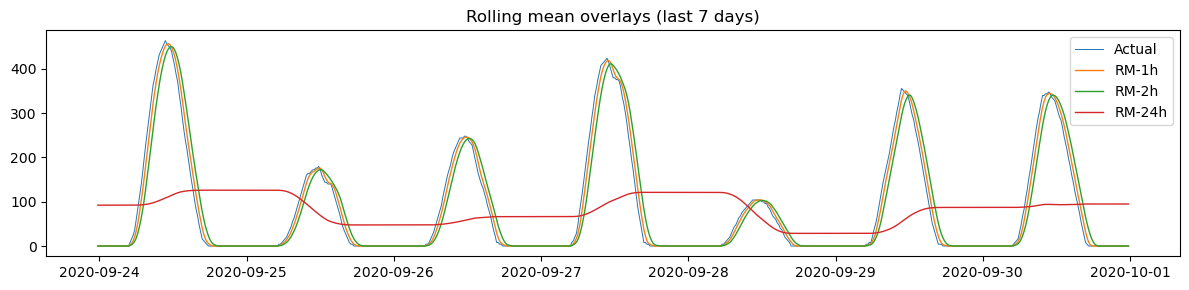

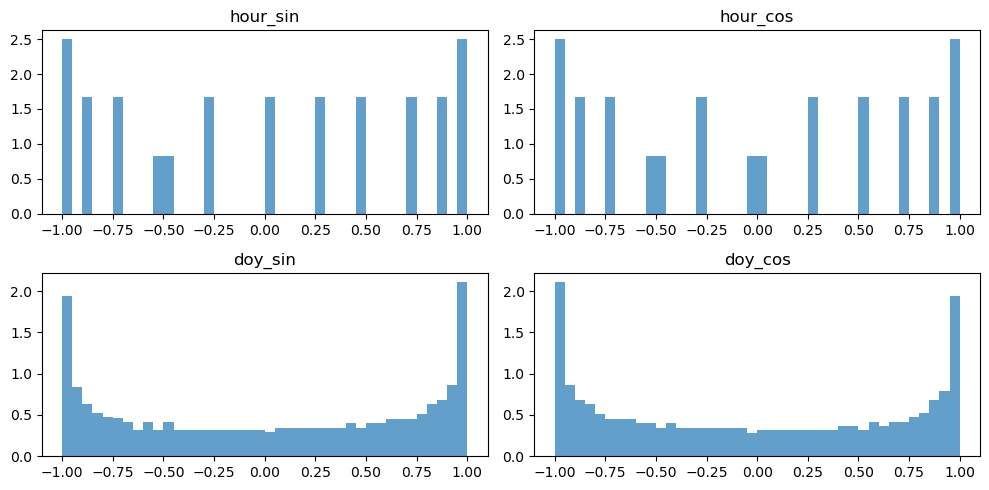

In [8]:
# --- DATA VISUALIZATION (2/2) ---
# Feature diagnostics: lag plots, rolling means, cyclic encodings.

sample = df_cleared.copy()
# Build minimal features for plotting relationships
sample["lag_1"] = sample["AT_solar_generation_actual"].shift(1)
sample["lag_4"] = sample["AT_solar_generation_actual"].shift(4)
sample["lag_96"] = sample["AT_solar_generation_actual"].shift(96)
sample = sample.dropna()

fig, axes = plt.subplots(1, 3, figsize=(12,3))
for ax, col in zip(axes, ["lag_1", "lag_4", "lag_96"]):
    ax.scatter(sample[col].values[::50], sample["AT_solar_generation_actual"].values[::50], s=4, alpha=0.5)
    ax.set_xlabel(col); ax.set_ylabel("y")
fig.suptitle("Lag plots"); plt.tight_layout(); plt.show()

# Rolling mean overlay (1h/2h/24h)
roll1 = df_cleared["AT_solar_generation_actual"].rolling(4).mean()
roll2 = df_cleared["AT_solar_generation_actual"].rolling(8).mean()
roll24 = df_cleared["AT_solar_generation_actual"].rolling(96).mean()
window_start = df_cleared.index.max() - pd.Timedelta(days=7)
mask = df_cleared.index >= window_start
plt.figure(figsize=(12,3))
plt.plot(df_cleared.index[mask], df_cleared["AT_solar_generation_actual"][mask], lw=0.7, label="Actual")
plt.plot(roll1.index[mask], roll1[mask], lw=1.0, label="RM-1h")
plt.plot(roll2.index[mask], roll2[mask], lw=1.0, label="RM-2h")
plt.plot(roll24.index[mask], roll24[mask], lw=1.0, label="RM-24h")
plt.title("Rolling mean overlays (last 7 days)"); plt.legend(); plt.tight_layout(); plt.show()

# Cyclic encodings distribution
idx = df_cleared.index
hour = idx.hour
doy = idx.dayofyear
hour_sin = np.sin(2*np.pi*hour/24)
hour_cos = np.cos(2*np.pi*hour/24)
doy_sin = np.sin(2*np.pi*doy/365.25)
doy_cos = np.cos(2*np.pi*doy/365.25)
fig, axes = plt.subplots(2,2, figsize=(10,5))
axes = axes.ravel()
for ax, arr, title in zip(axes,[hour_sin,hour_cos,doy_sin,doy_cos],["hour_sin","hour_cos","doy_sin","doy_cos"]):
    ax.hist(arr, bins=40, density=True, alpha=0.7)
    ax.set_title(title)
plt.tight_layout(); plt.show()

Persistence (val): MAE=10.136 RMSE=16.309 R2=0.994
Persistence (test): MAE=13.382 RMSE=20.578 R2=0.994
SMA4 (val): MAE=25.016 RMSE=39.567 R2=0.965
SMA4 (test): MAE=33.089 RMSE=50.390 R2=0.965
Ridge (val): MAE=3.012 RMSE=5.282 R2=0.999
Ridge (test): MAE=3.326 RMSE=5.443 R2=1.000


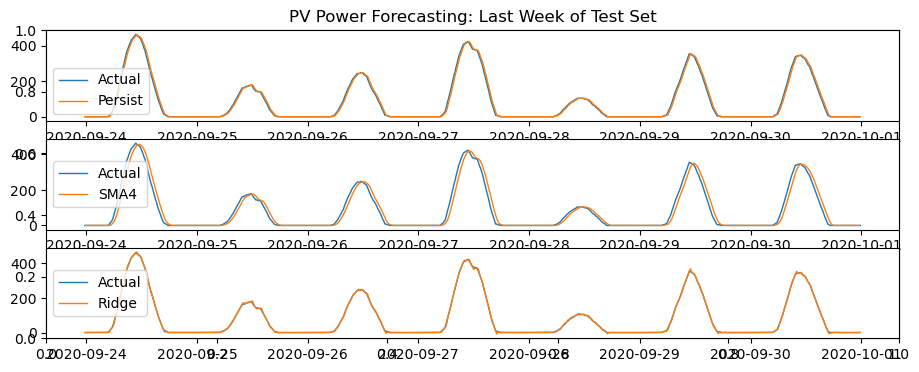

In [9]:
# --- Persistence、Simple moving average、 Ridge model ---

# Helper metrics
def eval_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label}: MAE={mae:.3f} RMSE={rmse:.3f} R2={r2:.3f}")
    return mae, rmse, r2

# Persistence (t -> t+1)
# For lag_1, we can use X features: prediction equals lag_1
persist_val = X_val["lag_1"].values
persist_test = X_test["lag_1"].values
eval_metrics(y_val, persist_val, "Persistence (val)")
eval_metrics(y_test, persist_test, "Persistence (test)")

# Simple moving average(last 4 steps)
sma4_val = X_val[["roll_mean_4"]].values.ravel()
sma4_test = X_test[["roll_mean_4"]].values.ravel()
eval_metrics(y_val, sma4_val, "SMA4 (val)")
eval_metrics(y_test, sma4_test, "SMA4 (test)")

# Ridge regression on engineered features
ridge = Ridge(alpha=1.0, random_state=None)
ridge.fit(X_train, y_train)
val_pred = ridge.predict(X_val)
test_pred = ridge.predict(X_test)

eval_metrics(y_val, val_pred, "Ridge (val)")
eval_metrics(y_test, test_pred, "Ridge (test)")

# Quick visualization for a recent window
plot_start = y_test.index.max() - pd.Timedelta(days=7)
clip = (y_test.index >= plot_start)

fig, ax = plt.subplots(figsize=(11,4))
ax.set_title("PV Power Forecasting: Last Week of Test Set")

ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(y_test.index[clip], y_test.values[clip], label="Actual", lw=1)
ax1.plot(y_test.index[clip], persist_test[clip], label="Persist", lw=1)
ax1.legend()

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(y_test.index[clip], y_test.values[clip], label="Actual", lw=1)
ax2.plot(y_test.index[clip], sma4_test[clip], label="SMA4", lw=1)
ax2.legend()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(y_test.index[clip], y_test.values[clip], label="Actual", lw=1)
ax3.plot(y_test.index[clip], test_pred[clip], label="Ridge", lw=1)
ax3.legend()